In [ ]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sbn
import numpy as np 

import torch

import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score, silhouette_samples
import umap
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

from amlvae.models.VAE import VAE 
from amlvae.train.Trainer import Trainer

from amlvae.data.ExprProcessor import ExprProcessor
from amlvae.data.ClinProcessor import ClinProcessor

from sklearn.model_selection import KFold

from sklearn.metrics import pairwise_distances

# auto reimport 
%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
expr_long = pd.read_csv('../../data/aml_train.csv')
clin = pd.read_csv('../../data/beataml_clinical_for_inputs.csv')
eproc = ExprProcessor(expr_long, target='fpkm_unstranded', norm='zscore_log2', top_genes=1000)
cproc = ClinProcessor(clin.set_index('gdc_id'), targets=['specimenType', 'consensus_sex', 'reportedRace'])
# cohort (waves 1+2, waves 3+4)

In [6]:
X_train, train_ids = eproc.get_data()
X_train = torch.tensor(X_train, dtype=torch.float32)

cond_train = cproc.get_data(train_ids)
cond_meta = {targ: cond_train[targ].shape[1] for targ in cond_train}
cond_train = {targ: torch.tensor(cond_train[targ].argmax(1), dtype=torch.long).view(-1) for targ in cond_train}

In [8]:
X_val, val_ids = eproc.process_new(pd.read_csv('../../data/aml_validation.csv'))
X_val = torch.tensor(X_val, dtype=torch.float32)

#cond_val = cproc.get_data(val_ids)
#cond_val = {targ: torch.tensor(cond_val[targ].argmax(1), dtype=torch.long).view(-1) for targ in cond_val}

In [9]:
X_test, test_ids = eproc.process_new(pd.read_csv('../../data/aml_test.csv'))
X_test = torch.tensor(X_test, dtype=torch.float32)

In [10]:
cond_test = cproc.get_data(test_ids)
cond_test = {targ: torch.tensor(cond_test[targ].argmax(1), dtype=torch.long).view(-1) for targ in cond_test}

In [22]:
model_kwargs = {
    'input_dim'   : X_train.size(1),
    'hidden_dims' : [250,50],
    'latent_dim'  : 10,
    'norm'        : 'layer',
    'variational' : True,
    'dropout'     : 0.,
    'nonlin'      : 'elu',
    'conditions'  : cond_meta,
    'alpha'       : 0.01
}

model = VAE(**model_kwargs).cuda()

trainer = Trainer(model, X_train.cuda(), X_val.cuda(), X_test.cuda(), device='cuda')

trainer.train(
    epochs        = 500,
    lr            = 1e-3,
    wd            = 0,
    beta          = 1.,
    cond_targets  = cond_train,
    batch_size    = 128,
    verbose       = True,
    log_every     = 10
)

device: cuda


In [23]:
model, res_dict = trainer.results(device='cuda')

In [24]:
res_dict

{'train': {'loss': 0.31210193037986755,
  'mse': 0.2865726947784424,
  'r2': 0.71286541223526,
  'r': np.float64(0.8391435839294803)},
 'val': {'loss': 0.5046044588088989,
  'mse': 0.4791353642940521,
  'r2': 0.3401558995246887,
  'r': np.float64(0.7327766298392284)},
 'test': {'loss': 0.44084393978118896,
  'mse': 0.4155929982662201,
  'r2': 0.49070581793785095,
  'r': np.float64(0.7084495161244845)}}

In [25]:
z_train, _ = model.encode(X_train.cuda())
z_val, _ = model.encode(X_val.cuda())
z_test, _ = model.encode(X_test.cuda())

In [31]:
z = torch.cat([z_train, z_val, z_test], dim=0).detach().cpu().numpy()
zdf = pd.DataFrame(z).assign(ids = train_ids.tolist() + val_ids.tolist() + test_ids.tolist()) 
zdf = zdf.merge(clin.set_index('gdc_id'), left_on='ids', right_index=True, how='left')
zdf.head()

0         1         2         3         4         5         6  \
0 -0.335330  1.071520 -1.704712 -1.705655  1.126338 -2.668741  0.691792   
1 -0.108182  1.550471 -0.456860 -1.127810  0.034012  0.316001  0.228821   
2 -0.741187 -0.289266 -1.207729  1.569929  1.126157  1.359787 -0.315211   
3 -0.550819 -0.317306  0.717791 -1.726571 -2.389775  0.674772  0.566042   
4 -0.242197 -1.431109 -0.137814  0.378465  0.293444  0.616784  0.051805   

          7         8         9  ...  \
0  0.027264  0.214649  0.335006  ...   
1 -0.924710  0.253034 -0.168977  ...   
2  0.457566  0.975621 -0.441945  ...   
3 -0.052379  0.362752 -0.730230  ...   
4  0.823661  1.404885  1.067968  ...   

                             dxAtSpecimenAcquisition  isTransformed priorMDS  \
0  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...          FALSE        n   
1  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...          FALSE        n   
2  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...          FALSE        n   
3  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...          FALSE        n   
4  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...          FALSE        n   

   FLT3-ITD allelic_ratio      NPM1                   RUNX1 ASXL1 TP53  \
0  positive      1.000000  negative                     NaN   NaN  NaN   
1  positive      0.449275  negative  RUNX1 (p.Q262*; 72.4%)   NaN  NaN   
2  negative      0.000000  positive                     NaN   NaN  NaN   
3  negative      0.000000  negative                     NaN   NaN  NaN   
4  negative      0.000000  positive                     NaN   NaN  NaN   

      ELN2017  
0     Adverse  
1     Adverse  
2   Favorable  
3  NonInitial  
4   Favorable  

[5 rows x 45 columns]

In [34]:
for col in ['specimenType', 'consensus_sex', 'reportedRace', 'cohort', 'FLT3-ITD', 'NPM1', 'ELN2017', 'fabBlastMorphology']:
    s = silhouette_score(zdf.values[:, :10], labels=zdf[col].astype('category').cat.codes)
    print(f'{col}: {s:.3f}')

specimenType: -0.026
consensus_sex: 0.007
reportedRace: -0.185
cohort: 0.013
FLT3-ITD: 0.017
NPM1: 0.050
ELN2017: -0.182
fabBlastMorphology: -0.111


/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


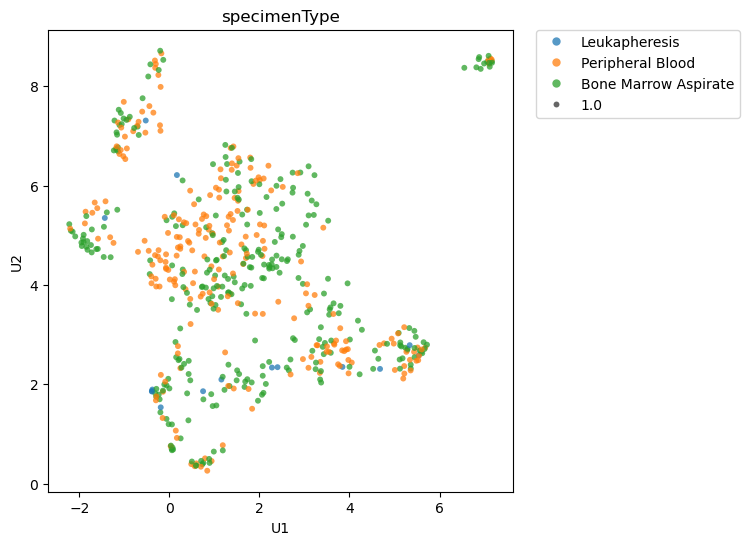

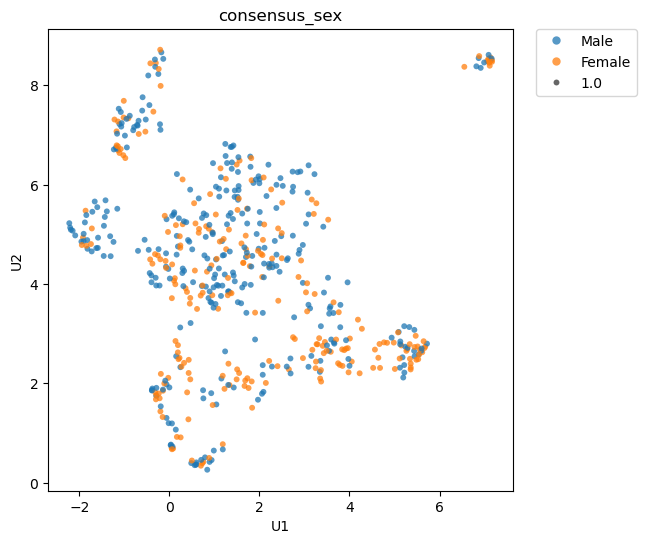

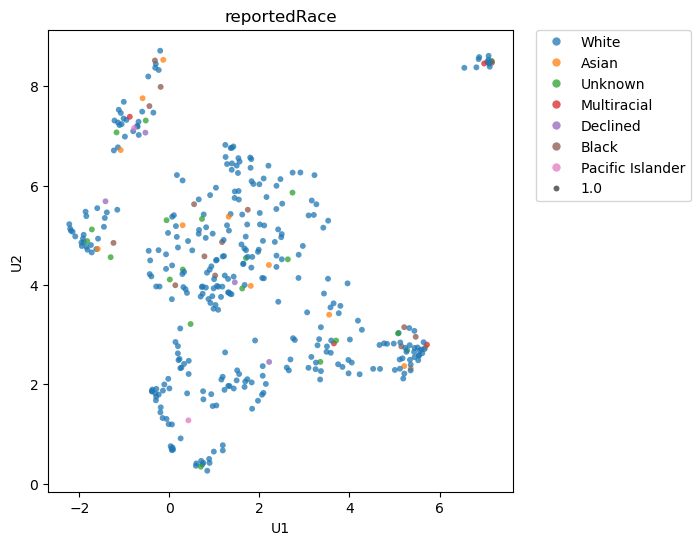

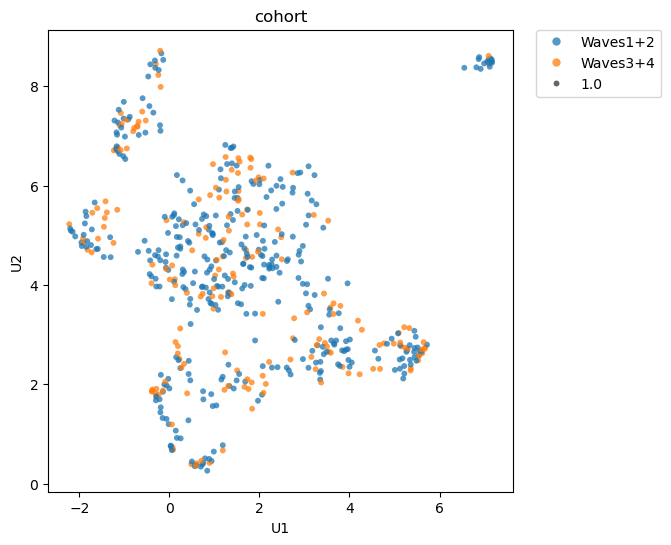

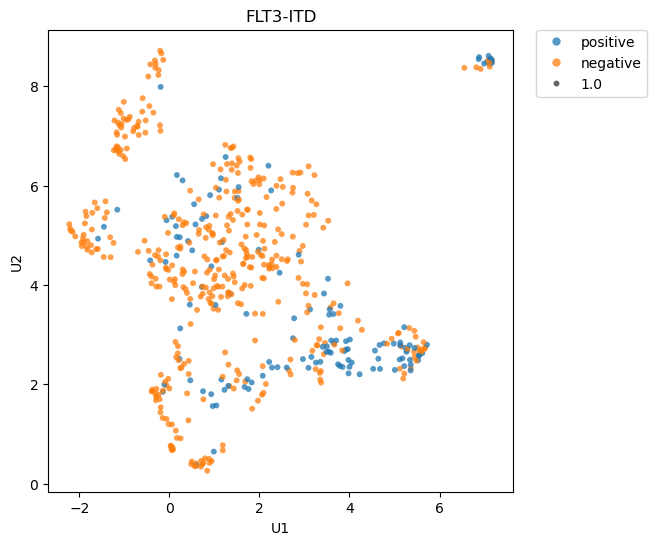

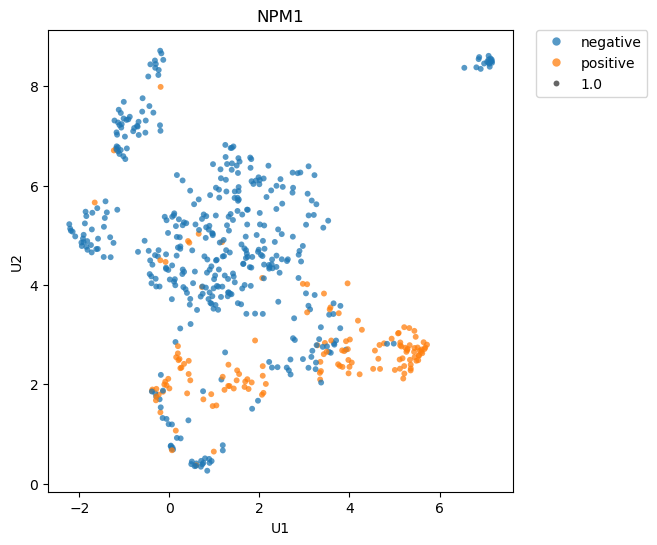

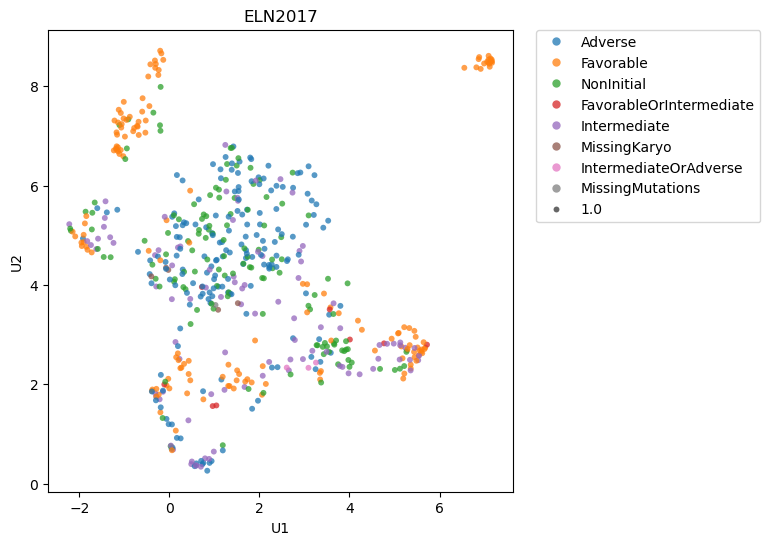

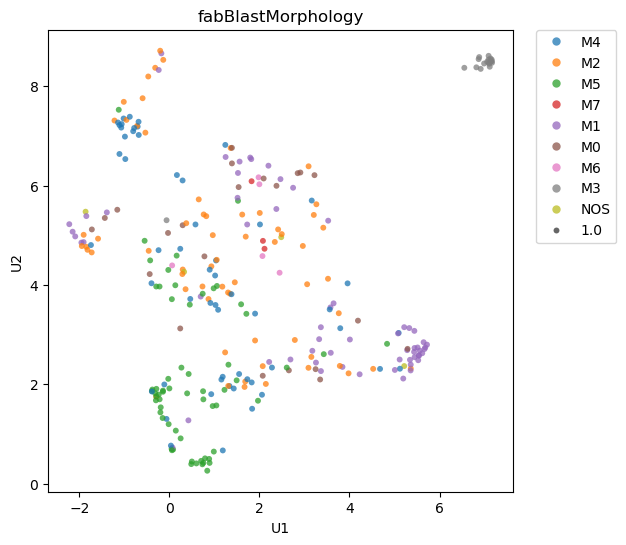

In [ ]:
u = umap.UMAP(n_neighbors=25, min_dist=0.1, metric='euclidean').fit_transform(z)

df = pd.DataFrame(u, columns=['U1', 'U2']).assign(
    partition = ['train']*len(z_train) + ['val']*len(z_val) + ['test']*len(z_test),
    gdc_id = train_ids.tolist() + val_ids.tolist() + test_ids.tolist()
)

df = df.merge(clin, on='gdc_id', how='left')

for col in ['specimenType', 'consensus_sex', 'reportedRace', 'cohort', 'FLT3-ITD', 'NPM1', 'ELN2017', 'fabBlastMorphology']:
    plt.figure(figsize=(6,6))
    sbn.scatterplot(data=df, x='U1', y='U2', hue=col, size=1., alpha=0.75, linewidth=0)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(col)
    plt.show()



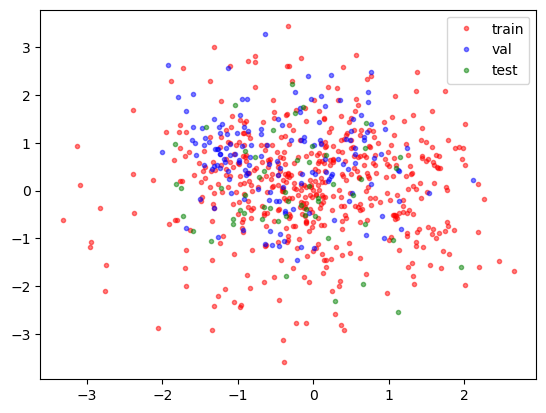

In [17]:
plt.figure()
plt.plot(z_train[:,0].cpu().detach().numpy(), z_train[:,1].cpu().detach().numpy(), 'r.', alpha=0.5, label='train')
plt.plot(z_val[:,0].cpu().detach().numpy(), z_val[:,1].cpu().detach().numpy(), 'b.', alpha=0.5, label='val')
plt.plot(z_test[:,0].cpu().detach().numpy(), z_test[:,1].cpu().detach().numpy(), 'g.', alpha=0.5, label='test')
plt.legend()
plt.show()


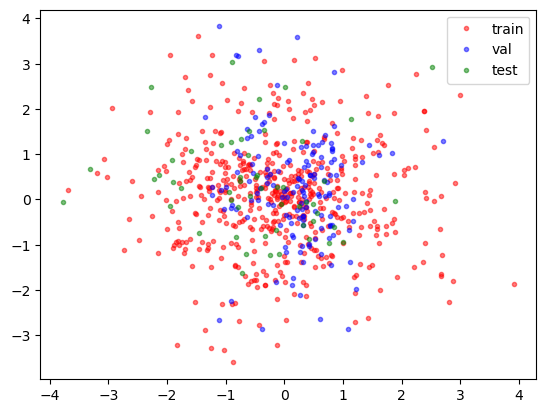

In [18]:
plt.figure()
plt.plot(z_train[:,2].cpu().detach().numpy(), z_train[:,3].cpu().detach().numpy(), 'r.', alpha=0.5, label='train')
plt.plot(z_val[:,2].cpu().detach().numpy(), z_val[:,3].cpu().detach().numpy(), 'b.', alpha=0.5, label='val')
plt.plot(z_test[:,2].cpu().detach().numpy(), z_test[:,3].cpu().detach().numpy(), 'g.', alpha=0.5, label='test')
plt.legend()
plt.show()

In [ ]:
from sklearn.decomposition import PCA

def run_pca(X, n_components=2, n_splits=5):

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    r2s = [] 
    pca_models = []
    for fold_idx, (train_idxs, val_idxs) in enumerate(kfold.split(X)):
        #print(f"\n=== Fold {fold_idx+1}/{n_splits} ===")

        # Extract train/val subsets (convert if X is a torch.Tensor)
        X_train = X[train_idxs].cpu().numpy()
        X_val   = X[val_idxs].cpu().numpy()

        # Initialize PCA
        pca = PCA(n_components=n_components)

        # Fit on the training fold
        pca.fit(X_train)

        # Compute explained variance on the training set
        explained_variance_train = np.sum(pca.explained_variance_ratio_)
        #print(f"Training Explained Variance (fold {fold_idx+1}): {explained_variance_train:.4f}")

        # Evaluate on the validation set: transform -> inverse transform -> R^2
        X_val_transformed    = pca.transform(X_val)
        X_val_reconstructed  = pca.inverse_transform(X_val_transformed)

        mse = np.mean((X_val - X_val_reconstructed)**2)

        r2 = r2_score(X_val, X_val_reconstructed, multioutput='uniform_average')
        #print(f"Validation R^2 (fold {fold_idx+1}): {r2:.4f}")
        #print(f"Validation MSE (fold {fold_idx+1}): {mse:.4f}")
        r2s += [r2]

        # Save the trained PCA model
        pca_models.append(pca)

    return pca_models, r2s

Running PCA with 2 components
Running PCA with 15 components
Running PCA with 29 components
Running PCA with 42 components
Running PCA with 56 components
Running PCA with 69 components
Running PCA with 83 components
Running PCA with 96 components
Running PCA with 110 components
Running PCA with 124 components


n_comps    r2_val
0        2  0.241219
1       15  0.577176
2       29  0.657286
3       42  0.689709
4       56  0.710528

In [ ]:

def run_vae(n_components=2, n_splits=5): 
    # Define the number of folds
    n_splits = 5

    # Set up the KFold object (random_state can be any integer for reproducibility)
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Prepare the VAE model keyword arguments
    model_kwargs = {
        'input_dim'   : X.size(1),
        'hidden_dims' : [256],
        'latent_dim'  : n_components,
        'norm'        : 'batch',
        'variational' : False,
        'dropout'     : 0.1,
        'nonlin'      : 'elu',
        #'conditions'  : conditions,
        'alpha'       : 1.
    }

    models = [] 
    r2s = [] 
    for fold_idx, (train_idxs, val_idxs) in enumerate(kfold.split(X)):
        #print(f"\n=== Fold {fold_idx+1}/{n_splits} ===")

        # Instantiate a new model for each fold
        model = VAE(**model_kwargs)
        #print('# parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

        # Create a fresh Trainer
        trainer = Trainer(model)

        # Train on this fold
        trainer.train(
            X             = X[train_idxs],
            epochs        = 100,
            lr            = 1e-3,
            wd            = 0,
            beta          = 0.,
            #cond_targets  = cond_targets2,
            batch_size    = 128,
            verbose       = False
        )

        val_metrics = trainer.eval(X[val_idxs])
        #print('val_metrics:', val_metrics) 

        models.append(trainer.model)
        r2s += [val_metrics['r2']]

    return models, r2s

Running VAE with 2 components
Running VAE with 15 components
Running VAE with 29 components
Running VAE with 42 components
Running VAE with 56 components
Running VAE with 69 components
Running VAE with 83 components
Running VAE with 96 components
Running VAE with 110 components
Running VAE with 124 components


n_comps    r2_val
0      632  7.133537
1      645  7.472537
2      659  7.554476
3      672  7.588031
4      686  7.608949

In [ ]:
res = {'n_comps': [], 'r2_val_pca': [], 'r2_val_vae': []}
for nc in np.linspace(2, 64, 20): 
    nc = int(nc)
    print(f"Running {int(nc)} components")
    pcas, r2s_pca = run_pca(X, n_components=int(nc), n_splits=3)
    vaes, r2s_vae = run_vae(n_components=int(nc), n_splits=3)
    res['n_comps'] += [nc]
    res['r2_val_pca'] += [np.mean(r2s_pca)]
    res['r2_val_vae'] += [np.mean(r2s_vae)]

res = pd.DataFrame(res)
res.head() 

Running 2 components
Running 5 components
Running 8 components
Running 11 components
Running 15 components
Running 18 components
Running 21 components
Running 24 components
Running 28 components
Running 31 components
Running 34 components
Running 37 components
Running 41 components
Running 44 components
Running 47 components
Running 50 components
Running 54 components
Running 57 components
Running 60 components
Running 64 components


n_comps  r2_val_pca  r2_val_vae
0        2    0.241219    0.276987
1        5    0.395463    0.462455
2        8    0.471810    0.540259
3       11    0.529363    0.577599
4       15    0.577177    0.607164

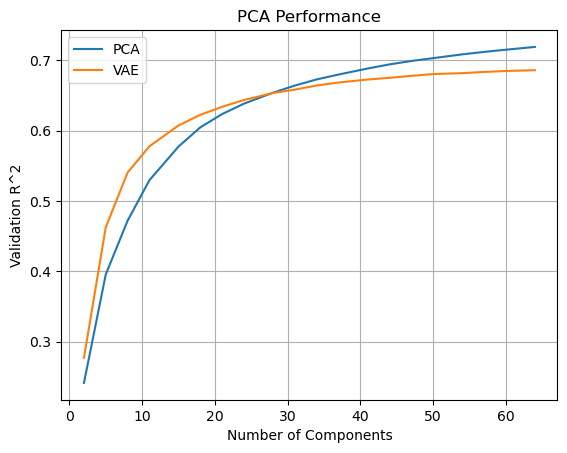

In [ ]:
plt.figure()
plt.plot(res['n_comps'], res['r2_val_pca'], label='PCA')
plt.plot(res['n_comps'], res['r2_val_vae'], label='VAE')
plt.xlabel('Number of Components')
plt.ylabel('Validation R^2')
plt.title('PCA Performance')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# adv 1.7 

/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


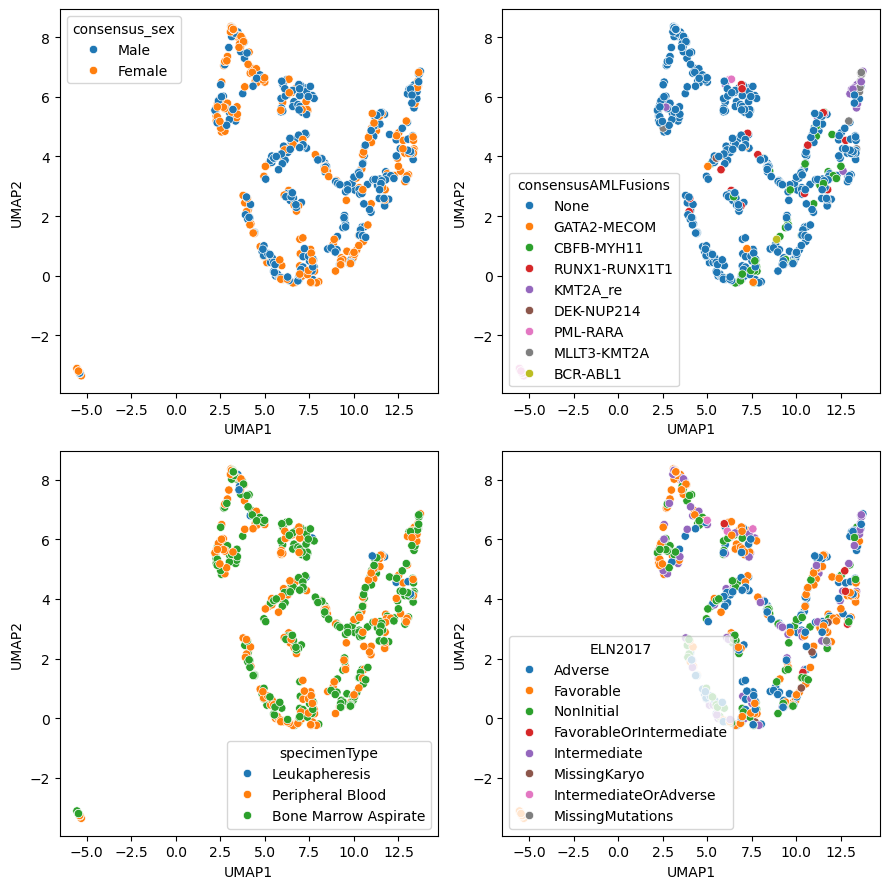

/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


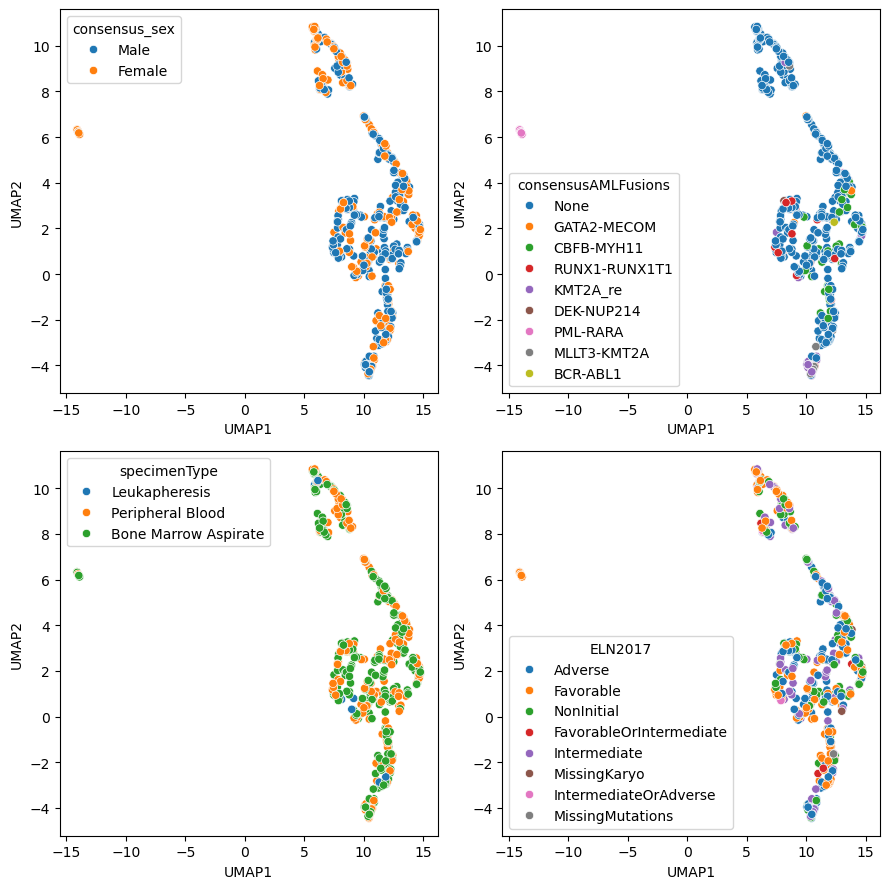

/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


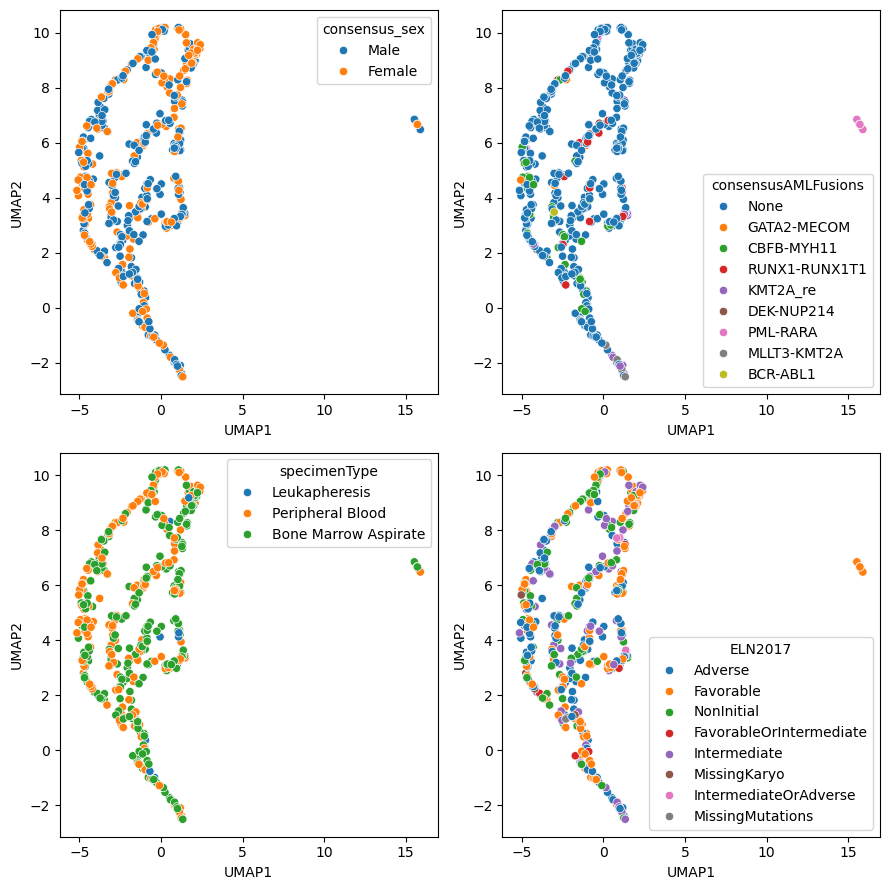

/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


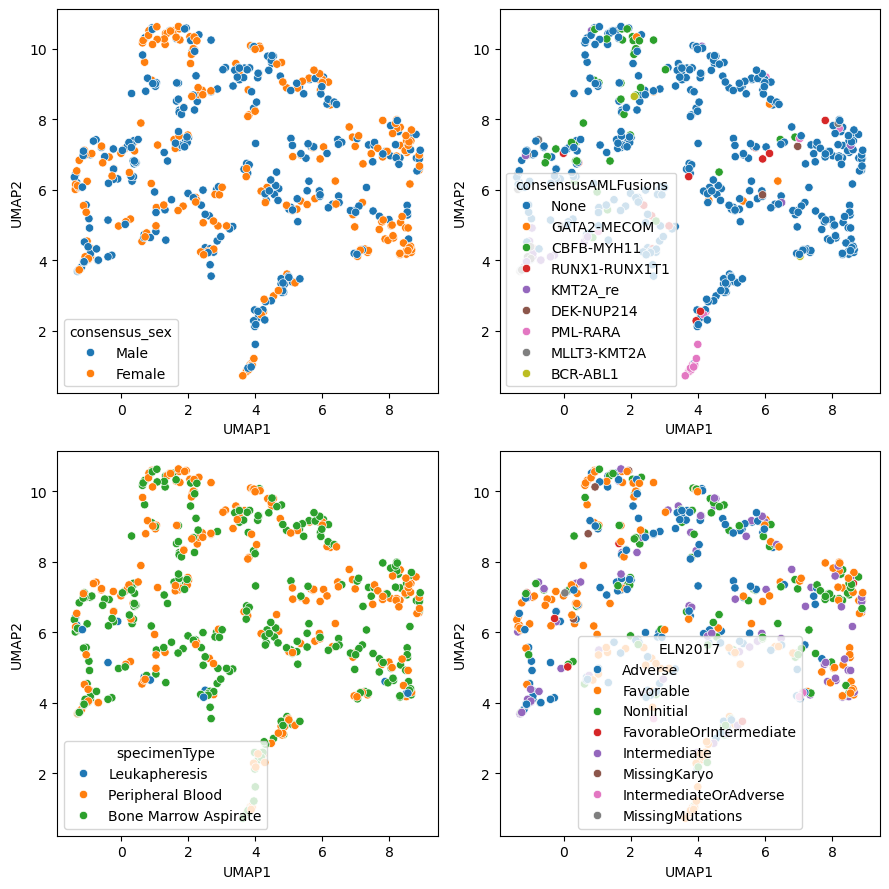

/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


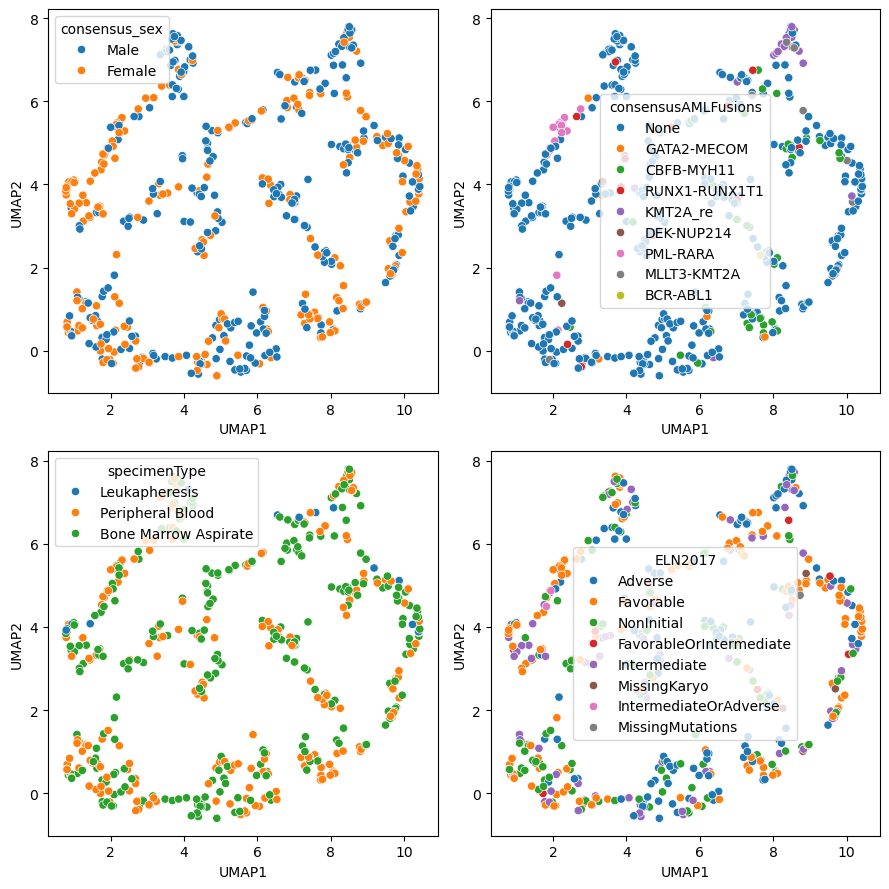

In [ ]:
dist_matrices = [] 
for model in models: 
    clin.consensusAMLFusions = clin.consensusAMLFusions.fillna('None')
    #model = trainer.get_best_model()
    z = model.encode(X)[0].detach().cpu().numpy()
    #z = model.encode(X).detach().cpu().numpy()

    reducer = umap.UMAP(n_neighbors=25, n_components=2, metric='euclidean', min_dist=0.1)
    u = reducer.fit_transform(z)

    ures = pd.DataFrame(u, columns=['UMAP1', 'UMAP2']).assign(gdc_id=patient_ids)
    ures = ures.merge(clin, on='gdc_id')

    f, axes = plt.subplots(2,2, figsize=(9,9))
    sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='consensus_sex', alpha=1., ax=axes[0,0])
    sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='consensusAMLFusions', alpha=1., ax=axes[0,1])
    sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='specimenType', alpha=1., ax=axes[1,0])
    sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='ELN2017', alpha=1., ax=axes[1,1])
    plt.tight_layout()
    plt.show()

    dist_matrix = pairwise_distances(z, metric='euclidean')
    dist_matrices.append(dist_matrix)

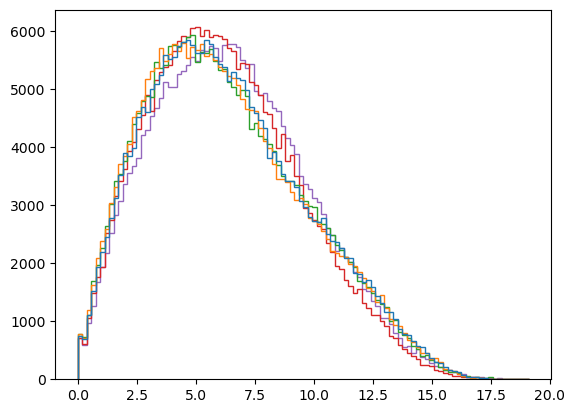

In [ ]:
plt.figure()
plt.hist([m.flatten() for m in dist_matrices], bins=100, histtype='step', label=[f'Fold {i+1}' for i in range(n_splits)])
plt.show() 

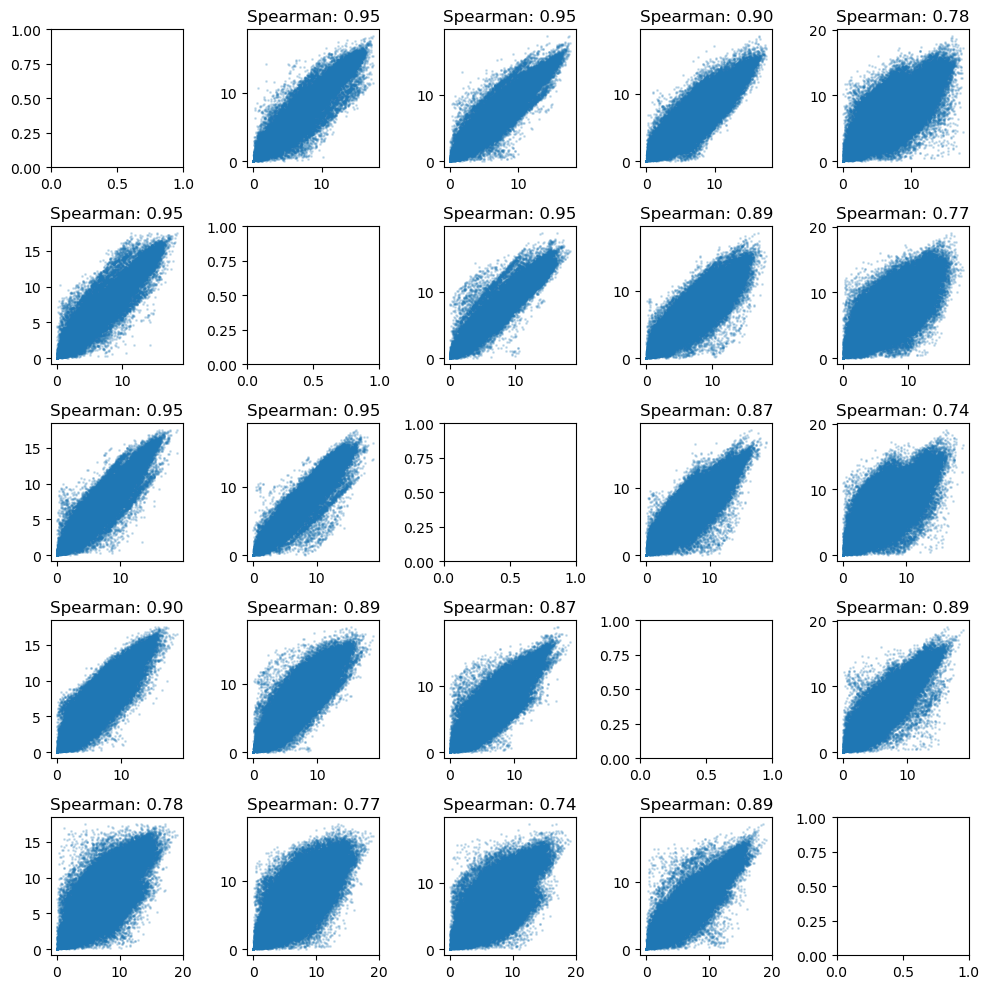

In [ ]:
f,axes = plt.subplots(n_splits, n_splits, figsize=(10,10))

for i in range(n_splits): 
    for j in range(n_splits): 
        if i == j: 
            continue 
        dist1 = dist_matrices[i]
        dist2 = dist_matrices[j]
        spearman = spearmanr(dist1.flatten(), dist2.flatten())[0]
        axes[i,j].scatter(dist1.flatten(), dist2.flatten(), s=1, alpha=0.1)
        axes[i,j].set_title(f'Spearman: {spearman:.2f}')

plt.tight_layout()
plt.show()

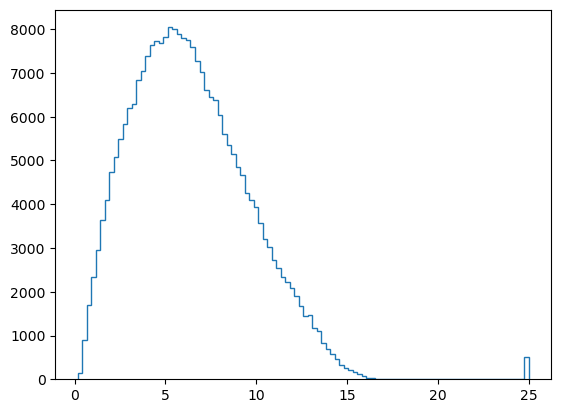

In [ ]:
avg_dist_matrix = np.stack(dist_matrices, -1).mean(-1)
# set diag to zero 
np.fill_diagonal(avg_dist_matrix, 25)

plt.figure()
plt.hist(avg_dist_matrix.flatten(), bins=100, histtype='step')
plt.show()

In [ ]:
avg_dist_matrix

array([[0.       , 4.5795197, 6.436558 , ..., 4.9270296, 7.6998873,
        4.839522 ],
       [4.5795197, 0.       , 6.2628365, ..., 5.159429 , 6.7647905,
        6.3977957],
       [6.436558 , 6.2628365, 0.       , ..., 6.8374963, 6.662256 ,
        5.432575 ],
       ...,
       [4.9270296, 5.159429 , 6.8374963, ..., 0.       , 7.0874505,
        3.8159127],
       [7.6998873, 6.7647905, 6.662256 , ..., 7.0874505, 0.       ,
        6.558023 ],
       [4.839522 , 6.3977957, 5.432575 , ..., 3.8159127, 6.558023 ,
        0.       ]], dtype=float32)

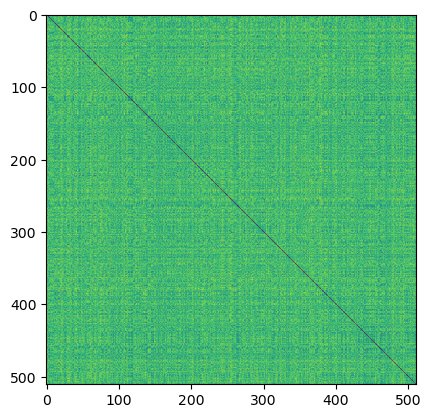

In [ ]:
plt.imshow(avg_dist_matrix, cmap='viridis')

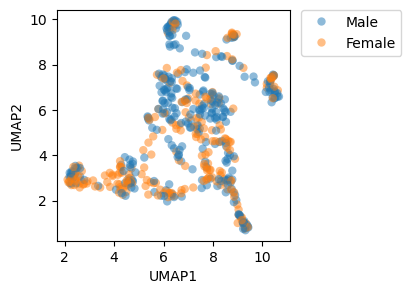

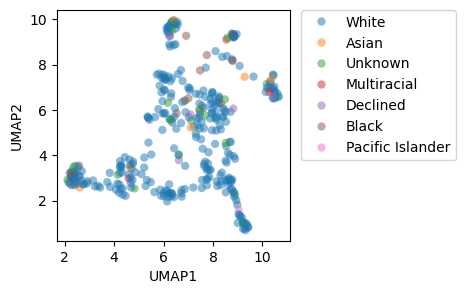

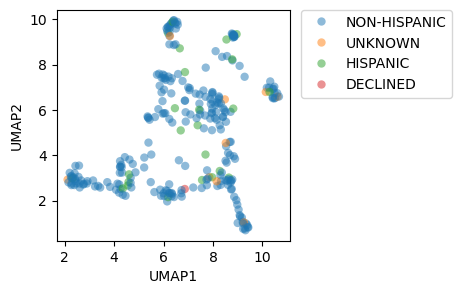

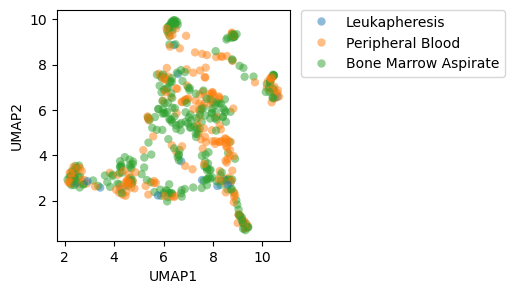

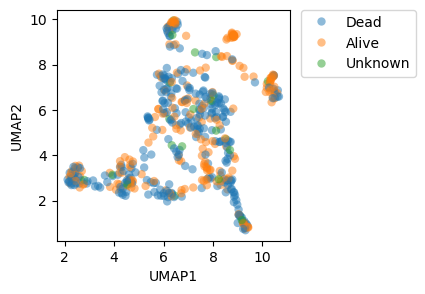

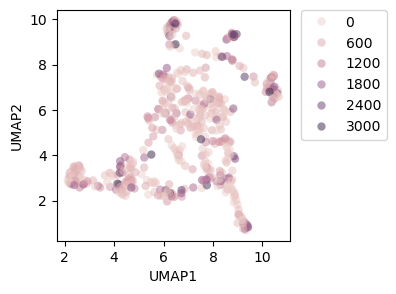

In [ ]:
for col in ['consensus_sex', 'reportedRace',
       'reportedEthnicity', 'specimenType', 
       'vitalStatus', 'overallSurvival']: 
    f, axes = plt.subplots(1,1, figsize=(3,3))
    sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue=col, ax=axes, linewidth=0, alpha=0.5)
    # move legend to the outside 
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    

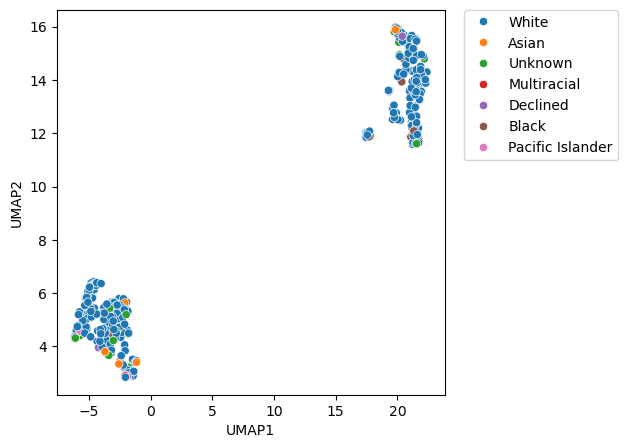

In [ ]:
f, axes = plt.subplots(1,1, figsize=(5,5))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='reportedRace', alpha=1., ax=axes)
# move legend to the outside 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

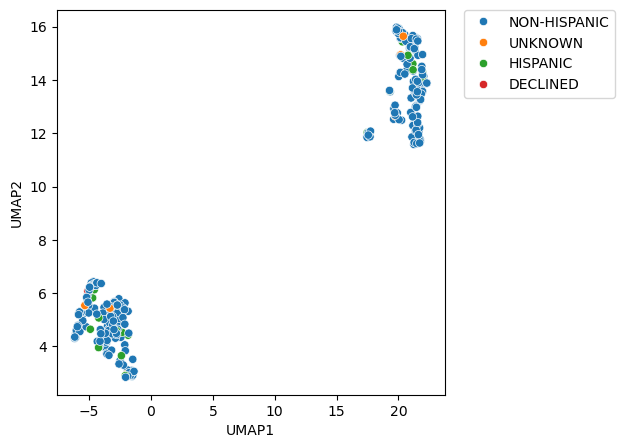

In [ ]:
f, axes = plt.subplots(1,1, figsize=(5,5))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='reportedEthnicity', alpha=1., ax=axes)
# move legend to the outside 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

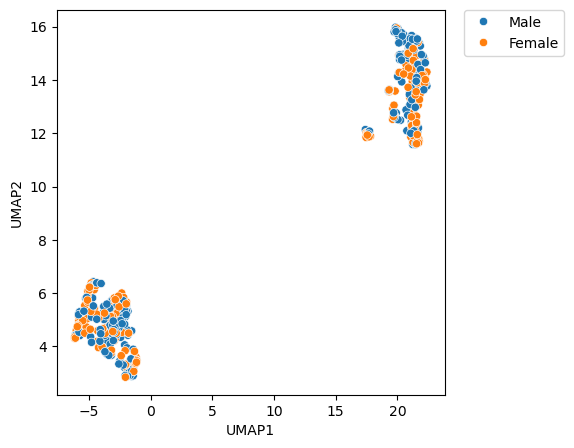

In [ ]:
f, axes = plt.subplots(1,1, figsize=(5,5))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='consensus_sex', alpha=1., ax=axes)
# move legend to the outside 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
mut_long = pd.read_csv('/home/teddy/local/TKG-DTI/data/tkg_raw/beataml_wes_wv1to4_mutations_dbgap.txt', sep='\t')
mut_long.head()

dbgap_sample_id capture_type seqnames  pos_start    pos_end ref    alt  \
0         BA2336D  NexteraV1.2        4  106156042  106156043  TC      T   
1         BA2336D  NexteraV1.2        4  106190829  106190830  AG      A   
2         BA2336D  NexteraV1.2        5  170837543  170837543   C  CTCTG   
3         BA2643D  NexteraV1.2       11   32456651   32456652  GC      G   
4         BA2643D  NexteraV1.2        2   25457242   25457242   C      T   

  genotyper  tumor_only  total_reads  ...   cdna_position  cds_position  \
0   varscan           1          151  ...      1804/10166      944/6009   
1   varscan           1           74  ...      4968/10166     4108/6009   
2   varscan           1           59  ...  1160-1161/1758   859-860/885   
3   varscan           1           51  ...        525/3122      240/1554   
4    mutect           1           28  ...       2983/4380     2645/2739   

   protein_position  amino_acids       codons  \
0          315/2002          S/X       tCc/tc   
1         1370/2002          G/X       Ggg/gg   
2           287/294        L/LCX  ctc/cTCTGtc   
3            80/517          L/X       ctG/ct   
4           882/912          R/H      cGc/cAc   

                 existing_variation                   refseq            sift  \
0                               NaN                      NaN             NaN   
1                       rs756348991                      NaN             NaN   
2            rs758959453&COSM158604              NM_002520.6             NaN   
3                               NaN  NM_024426.4&NM_024424.3             NaN   
4  rs147001633&COSM52944&COSM442676              NM_175629.2  deleterious(0)   

                   polyphen   exac_af  
0                       NaN       NaN  
1                       NaN  0.000037  
2                       NaN  0.000008  
3                       NaN       NaN  
4  probably_damaging(0.993)  0.000593  

[5 rows x 32 columns]

In [ ]:
# pivot to wide 
mut_long2 = mut_long# [lambda x: x.variant_classification.isin(['frameshift_variant', 'stop_gained'])]
mut = mut_long2.assign(mut=True)[['dbgap_sample_id', 'symbol', 'mut']].drop_duplicates().pivot(index='dbgap_sample_id', columns='symbol', values='mut').fillna(False)
mut.head()

/tmp/ipykernel_13472/1826861209.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mut = mut_long2.assign(mut=True)[['dbgap_sample_id', 'symbol', 'mut']].drop_duplicates().pivot(index='dbgap_sample_id', columns='symbol', values='mut').fillna(False)


symbol            A1CF    A2M  A4GALT  AADAC  AADACL3  AADACL4   AAK1  AARS2  \
dbgap_sample_id                                                                
BA2000D          False  False   False  False    False    False  False  False   
BA2003D          False  False   False  False    False    False  False  False   
BA2004D          False  False   False  False    False    False  False  False   
BA2005D          False  False   False  False    False    False  False  False   
BA2006D          False  False   False  False    False    False  False  False   

symbol            AASS   AATK  ...  ZNRF4    ZP3    ZP4  ZRANB1  ZRSR2  \
dbgap_sample_id                ...                                       
BA2000D          False  False  ...  False  False  False   False  False   
BA2003D          False  False  ...  False  False  False   False  False   
BA2004D          False  False  ...  False  False  False   False  False   
BA2005D          False  False  ...  False  False  False   False  False   
BA2006D          False  False  ...  False  False  False   False  False   

symbol           ZSCAN1  ZSCAN2  ZSWIM6   ZXDB  ZZEF1  
dbgap_sample_id                                        
BA2000D           False   False   False  False  False  
BA2003D           False   False   False  False  False  
BA2004D           False   False   False  False  False  
BA2005D           False   False   False  False  False  
BA2006D           False   False   False  False  False  

[5 rows x 3333 columns]

In [ ]:
ures2 = ures[lambda x: x.dbgap_dnaseq_sample.isin(mut.index)]
mut2 = mut.loc[ures2.dbgap_dnaseq_sample.values]

y1 = ures2.clus1.values
y2 = ures2.clus2.values

clus1_corrs = {'gene':[], 'r':[], 'pval':[], 'n':[]}
clus2_corrs = {'gene':[], 'r':[], 'pval':[], 'n':[]}
for gene in mut.columns: 
    x = mut2[gene].values
    r1 = spearmanr(y1, x)
    r2 = spearmanr(y2, x)
    clus1_corrs['gene'].append(gene)
    clus1_corrs['r'].append(r1.statistic)
    clus1_corrs['pval'].append(r1.pvalue)
    clus1_corrs['n'].append(x.sum())
    clus2_corrs['gene'].append(gene)
    clus2_corrs['r'].append(r2.statistic)
    clus2_corrs['pval'].append(r2.pvalue)
    clus2_corrs['n'].append(x.sum())

clus1_corrs = pd.DataFrame(clus1_corrs).fillna(1)
clus2_corrs = pd.DataFrame(clus2_corrs).fillna(1)

clus1_corrs = clus1_corrs.assign(pval_adj = multipletests(clus1_corrs.pval, method='fdr_bh')[1])
clus2_corrs = clus2_corrs.assign(pval_adj = multipletests(clus2_corrs.pval, method='fdr_bh')[1])

AttributeError: 'DataFrame' object has no attribute 'clus1'

In [ ]:
clus1_corrs.sort_values('pval_adj', ascending=True).head().style.hide()

NameError: name 'clus1_corrs' is not defined

In [ ]:
clus2_corrs.sort_values('pval_adj', ascending=True).head().style.hide()

NameError: name 'clus2_corrs' is not defined

In [ ]:
ures3.head()

NameError: name 'ures3' is not defined

/tmp/ipykernel_13472/4020125993.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ures3.CEBPA = ures3.CEBPA.fillna(False)
/tmp/ipykernel_13472/4020125993.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ures3.GATA2 = ures3.GATA2.fillna(False)
/tmp/ipykernel_13472/4020125993.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ures3.NP

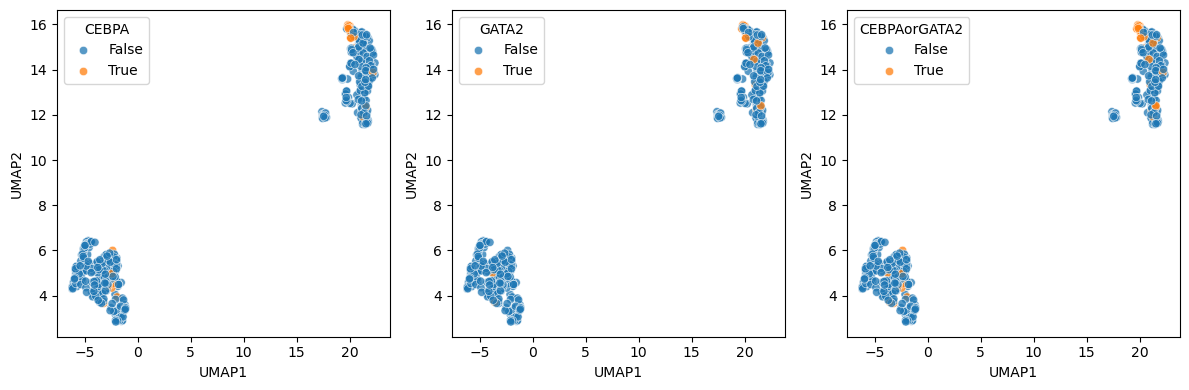

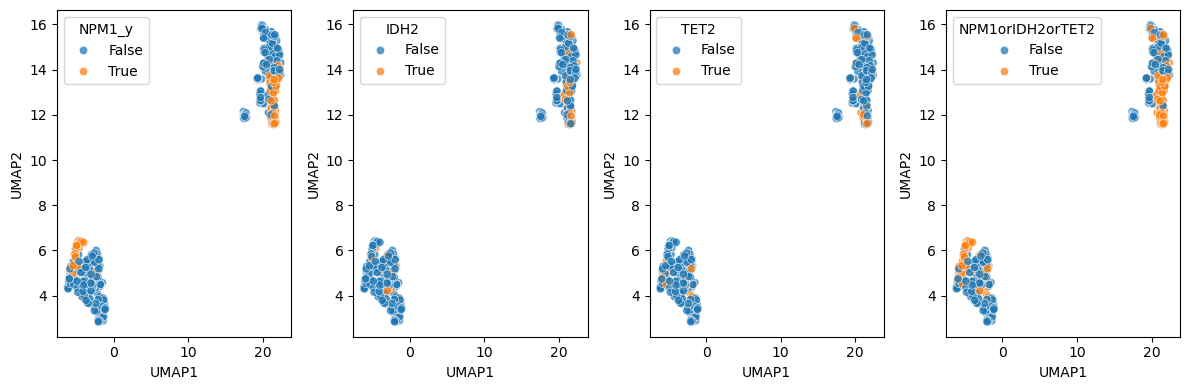

In [ ]:
_alpha = 0.75

ures3 = ures.merge(mut.reset_index()[['dbgap_sample_id', 'CEBPA', 'GATA2', 'NPM1', 'IDH2', 'TET2']], left_on='dbgap_dnaseq_sample', right_on='dbgap_sample_id', how='left')
ures3.CEBPA = ures3.CEBPA.fillna(False)
ures3.GATA2 = ures3.GATA2.fillna(False)
ures3.NPM1_y = ures3.NPM1_y.fillna(False)
ures3.IDH2 = ures3.IDH2.fillna(False)
ures3.TET2 = ures3.TET2.fillna(False)
ures3 = ures3.assign(CEBPAorGATA2 = ures3.CEBPA | ures3.GATA2)
ures3 = ures3.assign(NPM1orIDH2orTET2 = ures3.NPM1_y | ures3.IDH2 | ures3.TET2)

f,axes = plt.subplots(1,3, figsize=(12,4))
sbn.scatterplot(x='UMAP1', y='UMAP2', hue='CEBPA', data=ures3, ax=axes[0], alpha=_alpha)
sbn.scatterplot(x='UMAP1', y='UMAP2', hue='GATA2', data=ures3, ax=axes[1], alpha=_alpha)
sbn.scatterplot(x='UMAP1', y='UMAP2', hue='CEBPAorGATA2', data=ures3, ax=axes[2], alpha=_alpha)
plt.tight_layout()
plt.show()

f,axes = plt.subplots(1,4, figsize=(12,4))
sbn.scatterplot(x='UMAP1', y='UMAP2', hue='NPM1_y', data=ures3, ax=axes[0], alpha=_alpha)
sbn.scatterplot(x='UMAP1', y='UMAP2', hue='IDH2', data=ures3, ax=axes[1], alpha=_alpha)
sbn.scatterplot(x='UMAP1', y='UMAP2', hue='TET2', data=ures3, ax=axes[2], alpha=_alpha)
sbn.scatterplot(x='UMAP1', y='UMAP2', hue='NPM1orIDH2orTET2', data=ures3, ax=axes[3], alpha=_alpha)
plt.tight_layout()
plt.show()

In [ ]:
clin = pd.read_csv('../../../beataml_clinical_for_inputs.csv')

: 

In [ ]:
def run(gene_ixs, clin, verbose=True, num_epochs=100, batch_size=1000, lr=1e-3, return_model=False): 

    X = torch.tensor(expr.values, dtype=torch.float32)
    X = X[:, gene_ixs]
    
    torch.cuda.empty_cache()

    # Initialize model, criterion, optimizer, and device
    input_dim = X.shape[1]
    hidden_dims = [1012, 512]
    latent_dim = 124
    model = VAE(input_dim, hidden_dims, latent_dim)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    crit = loss_function
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='max', factor=0.5, patience=1000, threshold=1e-3)

    # Split data into training and validation sets
    num_samples = X.size(0)
    num_train = int(0.9 * num_samples)
    train_data, val_data = torch.utils.data.random_split(X, [num_train, num_samples - num_train])

    best_state = None 
    best_loss = np.inf

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        jj = 0
        for i in range(0, len(train_data), batch_size):
            batch = train_data[i:i+batch_size].to(device)
            optim.zero_grad()
            recon_x,  mu, logvar = model(batch)
            loss = crit(batch, recon_x, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optim.step()
            jj += 1

        # Validation
        model.eval()
        val_loss = 0
        r2_total = 0
        kk = 0
        with torch.no_grad():
            for i in range(0, len(val_data), batch_size):
                batch = val_data[i:i+batch_size].to(device)
                recon_batch, mu, logvar = model(batch)
                mse = F.mse_loss(recon_batch, batch, reduction='mean')
                r2 = r2_score(batch.cpu().numpy(), recon_batch.cpu().numpy(), multioutput='uniform_average')
                r = np.mean([np.corrcoef(batch[i].cpu().numpy(), recon_batch[i].cpu().numpy())[0, 1] for i in range(batch.size(0))])
                val_loss += loss.item()
                r2_total += r2
                kk += 1
                val_loss = crit(batch, recon_batch, mu, logvar)

        avg_loss = val_loss / kk
        r2_avg = r2_total / kk
        r_avg = r / kk
        scheduler.step(r2_avg)
        lr = scheduler.get_last_lr()[0]

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_state = model.state_dict()

        if verbose: print(f'Epoch {epoch+1}, Train Loss: {train_loss/jj:.4f}, Val Loss: {val_loss/kk:.4f}, val MSE: {mse:.3f}, val R2: {r2_avg:.3f} -> lr: {lr:.2E}', end='\r')

    model.load_state_dict(best_state)

    z = model.cpu().encode(X)[0].detach().numpy()

    clin = clin.set_index('gdc_id')

    labels = clin.loc[expr.index]['consensusAMLFusions'].values

    # convert labels from string to integer 
    labels = pd.Categorical(labels).codes

    idxs = labels != -1
    labels = labels[idxs]
    z = z[idxs]

    if return_model: 
        return model 
    else: 
        return silhouette_score(z, labels)

: 

In [ ]:
run((sd.values > np.quantile(sd, 0.95)).nonzero()[0], clin, verbose=True, num_epochs=100, batch_size=1000, lr=1e-3)

0.15649801

: 

In [ ]:
#theta = torch.nn.Parameter(torch.zeros(expr.shape[1], dtype=torch.float32), requires_grad=True)
#init_val = (sd.values - sd.values.mean())/sd.values.std()
# theta = torch.nn.Parameter(torch.tensor(init_val, dtype=torch.float32), requires_grad=True)

high_var_idxs = np.where(sd.values > np.quantile(sd, 0.75))[0]
n_high_var = len(high_var_idxs)
theta = torch.nn.Parameter(torch.zeros(n_high_var, dtype=torch.float32), requires_grad=True)

opt = torch.optim.Adam([theta], lr=1e-1)

rewards = [] 
for i in range(2500): 

    m = torch.distributions.Bernoulli(logits=theta)
    action = m.sample()
    ixs = torch.where(action == 1)[0].numpy()
    gene_ixs = high_var_idxs[ixs]

    reward = run(gene_ixs, clin, verbose=False, num_epochs=150)
    reward = np.clip(reward, -1, 1)
    rewards.append(reward)
    d = np.mean(rewards[-10:])
    adv = (reward - d)/(np.std(rewards[-10:]) + 1e-8)

    opt.zero_grad()

    loss = -m.log_prob(action).mean() * adv
    loss.backward()
    opt.step()

    print(f'iter: {i} ||>>|| reward: {reward:.3f} || advantage: {adv.item():.3f} || d: {d:.3f} || n actions: {action.sum().item()}')

iter: 0 ||>>|| reward: 0.134 || advantage: 0.000 || d: 0.134 || n actions: 2494.0
iter: 1 ||>>|| reward: 0.132 || advantage: -1.000 || d: 0.133 || n actions: 2535.0
iter: 2 ||>>|| reward: 0.134 || advantage: 0.652 || d: 0.133 || n actions: 2495.0
iter: 3 ||>>|| reward: 0.132 || advantage: -1.172 || d: 0.133 || n actions: 2511.0
iter: 4 ||>>|| reward: 0.129 || advantage: -1.692 || d: 0.132 || n actions: 2474.0
iter: 5 ||>>|| reward: 0.128 || advantage: -1.580 || d: 0.131 || n actions: 2476.0
iter: 6 ||>>|| reward: 0.137 || advantage: 1.599 || d: 0.132 || n actions: 2465.0
iter: 7 ||>>|| reward: 0.126 || advantage: -1.608 || d: 0.131 || n actions: 2513.0
iter: 8 ||>>|| reward: 0.133 || advantage: 0.531 || d: 0.132 || n actions: 2455.0
iter: 9 ||>>|| reward: 0.136 || advantage: 1.135 || d: 0.132 || n actions: 2443.0
iter: 10 ||>>|| reward: 0.130 || advantage: -0.588 || d: 0.132 || n actions: 2555.0
iter: 11 ||>>|| reward: 0.117 || advantage: -2.382 || d: 0.130 || n actions: 2477.0
iter: 1

: 

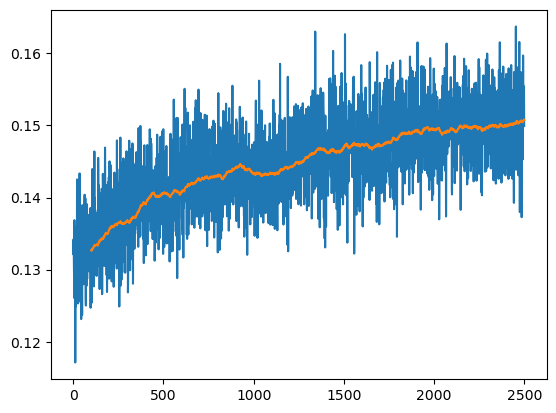

: 

In [ ]:
plt.figure()
plt.plot(rewards)
# plot average reward over last 10 iterations
plt.plot(pd.Series(rewards).rolling(100).mean().values)
plt.show()

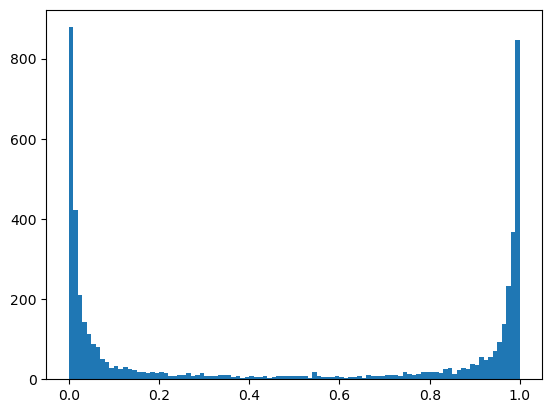

: 

In [ ]:
plt.figure()
plt.hist(theta.sigmoid().detach().numpy(), bins=100)
plt.show()

0.032463017849151586


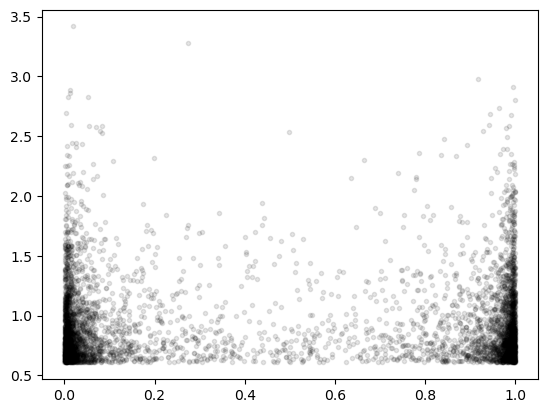

: 

In [ ]:
print(np.corrcoef(theta.sigmoid().detach().cpu().numpy(), sd.values[high_var_idxs])[0,1])

plt.figure()
plt.plot(theta.sigmoid().detach().cpu().numpy(), sd.values[high_var_idxs], 'k.', alpha=0.1)
plt.show()

: 

In [ ]:
gene_ixs = high_var_idxs[(theta.sigmoid().detach().numpy() > 0.5).nonzero()[0]]

model = run(gene_ixs, clin, verbose=True, num_epochs=200, batch_size=1000, lr=1e-3, return_model=True)

: 

In [ ]:
#X = torch.tensor(expr.values, dtype=torch.float32)
#z = model.cpu().encode(X[:, gene_ixs])[0].detach().numpy()

#X = torch.tensor(expr.values, dtype=torch.float32)
# get top 2000 most variable genes 
#top_2k_idxs = np.sort( np.argsort(sd.values)[::-1][:2000] ) 
#z = X[:, top_2k_idxs] 
model = trainer.get_best_model()
z = model.encode(X)[0].detach().cpu().numpy()

reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean')
u = reducer.fit_transform(z)

ures = pd.DataFrame(u, columns=['UMAP1', 'UMAP2']).assign(gdc_id=expr.index)
ures = ures.merge(clin, on='gdc_id')
ures = ures.fillna('none')
ures.head()


/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP1     UMAP2                                gdc_id  patientId  \
0  0.723483  1.002065  001454b2-aff9-4659-85a6-73fb8092589a        825   
1  0.536965  2.727864  002cacd9-c03b-4526-a380-0701f41c4a9e       1675   
2 -0.823124  6.581014  006e5777-2603-4db7-a1d6-8c8085c5e3e5       4930   
3 -0.355028  2.363687  00870f33-cab3-4c23-bd0d-8903a5a9789e       2205   
4 -1.864946  2.751128  00b535f6-064a-4dcf-ab14-387a54eedeee       4028   

      labId  dbgap_subject_id dbgap_rnaseq_sample dbgap_dnaseq_sample rna_set  \
0  12-00294              2518             BA2751R                none   train   
1  14-00488              2354             BA2405R             BA2405D   train   
2  18-00173              2657             BA3297R             BA3297D   train   
3  15-00559              2064             BA2589R             BA2589D   train   
4  16-00810              2414             BA2098R             BA2098D   train   

  dna_set  ...                            dxAtSpecimenAcquisition  \
0    none  ...  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   
1   train  ...  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   
2   train  ...  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   
3   train  ...  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   
4   train  ...  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   

  isTransformed priorMDS  FLT3-ITD allelic_ratio      NPM1  \
0         FALSE        n  positive           1.0  negative   
1         FALSE        n  positive      0.449275  negative   
2         FALSE        n  negative           0.0  positive   
3         FALSE        n  negative           0.0  negative   
4         FALSE        n  negative           0.0  positive   

                    RUNX1 ASXL1  TP53     ELN2017  
0                    none  none  none     Adverse  
1  RUNX1 (p.Q262*; 72.4%)  none  none     Adverse  
2                    none  none  none   Favorable  
3                    none  none  none  NonInitial  
4                    none  none  none   Favorable  

[5 rows x 36 columns]

: 

In [ ]:
ures.columns

Index(['UMAP1', 'UMAP2', 'gdc_id', 'patientId', 'labId', 'dbgap_subject_id',
       'dbgap_rnaseq_sample', 'dbgap_dnaseq_sample', 'rna_set', 'dna_set',
       'cohort', 'manuscript_rnaseq', 'manuscript_dnaseq', 'consensus_sex',
       'reportedRace', 'reportedEthnicity', 'specimenType', 'isDenovo',
       'ageAtDiagnosis', 'consensusAMLFusions', '%.Blasts.in.BM',
       '%.Blasts.in.PB', 'vitalStatus', 'overallSurvival',
       'diseaseStageAtSpecimenCollection', 'specimenGroups',
       'dxAtSpecimenAcquisition', 'isTransformed', 'priorMDS', 'FLT3-ITD',
       'allelic_ratio', 'NPM1', 'RUNX1', 'ASXL1', 'TP53', 'ELN2017'],
      dtype='object')

: 

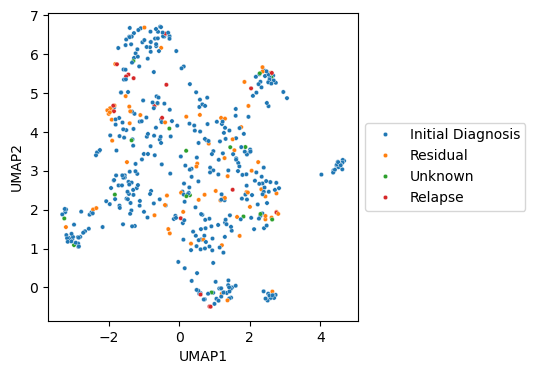

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='diseaseStageAtSpecimenCollection', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

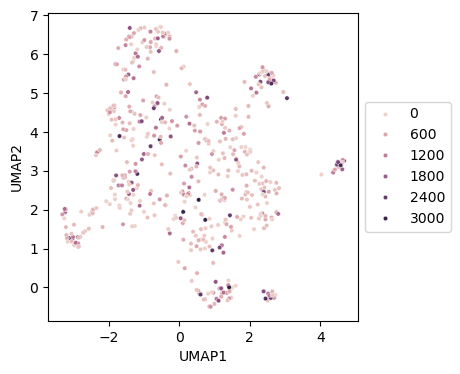

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='overallSurvival', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

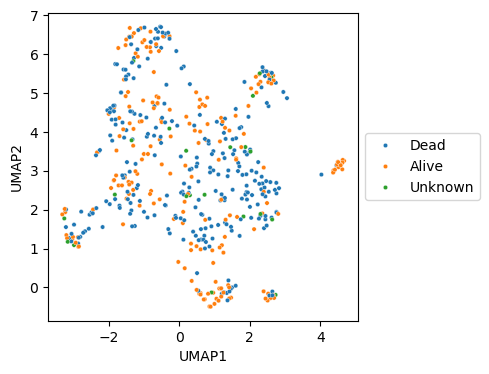

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='vitalStatus', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

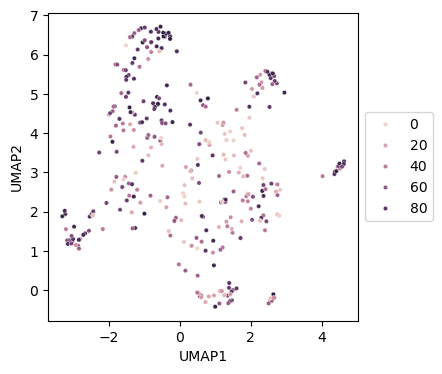

: 

In [ ]:
ures['%.Blasts.in.PB'] = pd.to_numeric(ures['%.Blasts.in.PB'], errors='coerce')
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures[lambda x: ~x['%.Blasts.in.PB'].isna()], x='UMAP1', y='UMAP2', hue='%.Blasts.in.PB', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

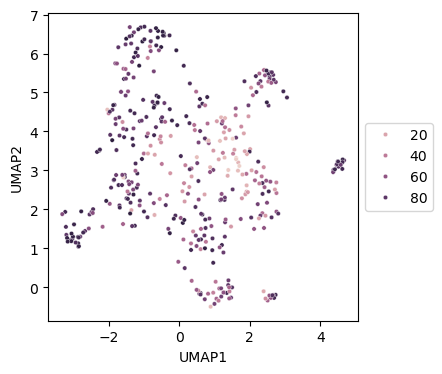

: 

In [ ]:
ures['%.Blasts.in.BM'] = pd.to_numeric(ures['%.Blasts.in.BM'], errors='coerce')
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures[lambda x: ~x['%.Blasts.in.BM'].isna()], x='UMAP1', y='UMAP2', hue='%.Blasts.in.BM', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


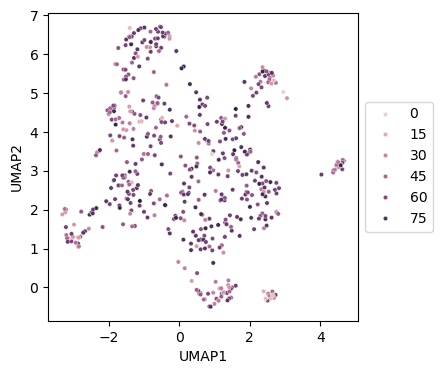

: 

In [ ]:
#ures['ageAtDiagnosis'] = ures['ageAtDiagnosis'].astype(float)
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures[lambda x: x.ageAtDiagnosis != 'none'], x='UMAP1', y='UMAP2', hue='ageAtDiagnosis', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

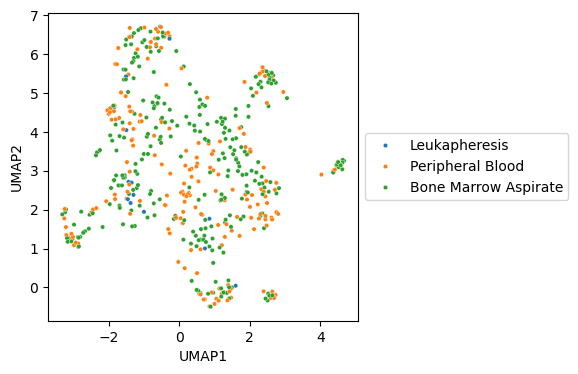

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='specimenType', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

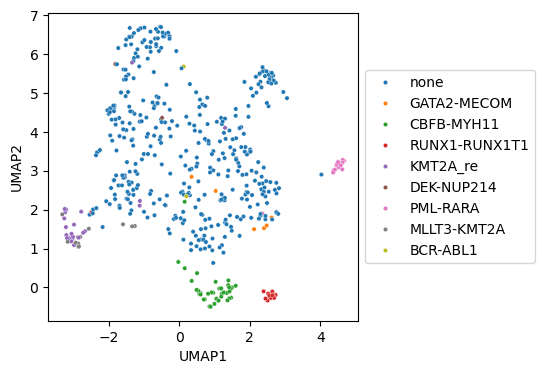

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='consensusAMLFusions', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

In [ ]:
clin = clin.set_index('gdc_id')
labels = clin.loc[expr.index]['consensusAMLFusions'].values

# convert labels from string to integer 
labels = pd.Categorical(labels).codes

idxs = labels != -1
labels = labels[idxs]
z = z[idxs]

silhouette_score(z, labels)

KeyError: "None of ['gdc_id'] are in the columns"

: 

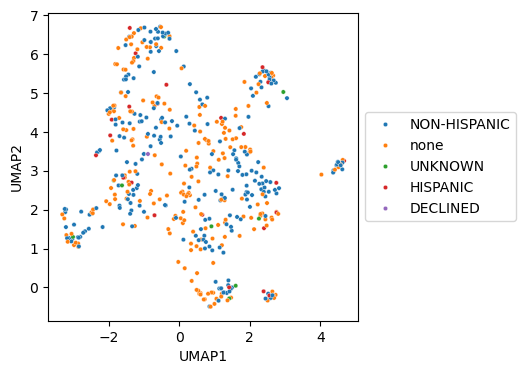

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='reportedEthnicity', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

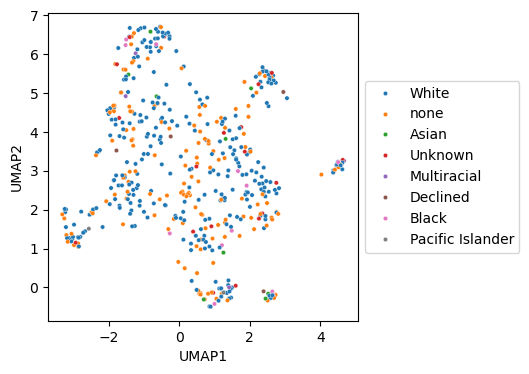

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='reportedRace', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

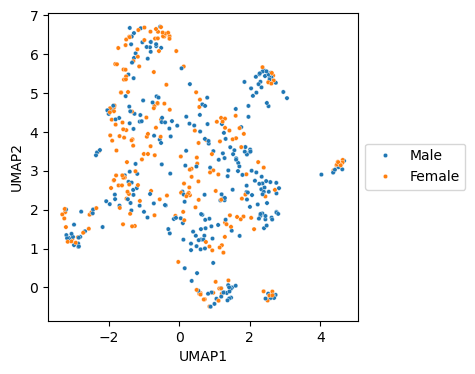

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='consensus_sex', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

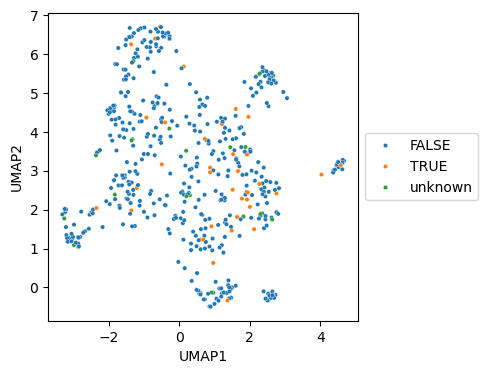

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='isTransformed', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(9, 4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='FLT3-ITD', s=10, ax=axes[0])
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='NPM1', s=10, ax=axes[1])
plt.tight_layout()
plt.show()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efe07d32340>
Traceback (most recent call last):
  File "/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/teddy/miniconda3/envs/amlvae/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/teddy/miniconda3/envs/amlvae/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/teddy/miniconda3/envs/amlvae/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^

: 

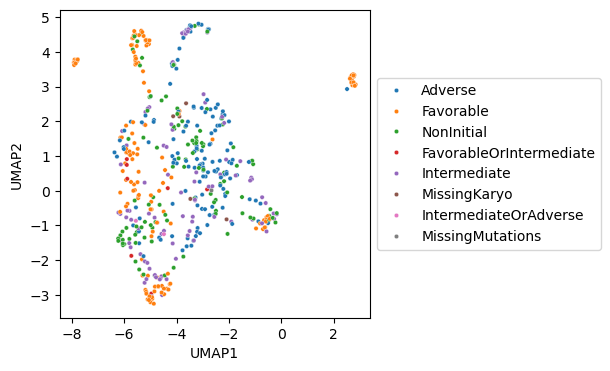

: 

: 

In [ ]:
plt.figure(figsize=(4,4))
sbn.scatterplot(data=ures, x='UMAP1', y='UMAP2', hue='ELN2017', s=10)
# put legend on outside 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

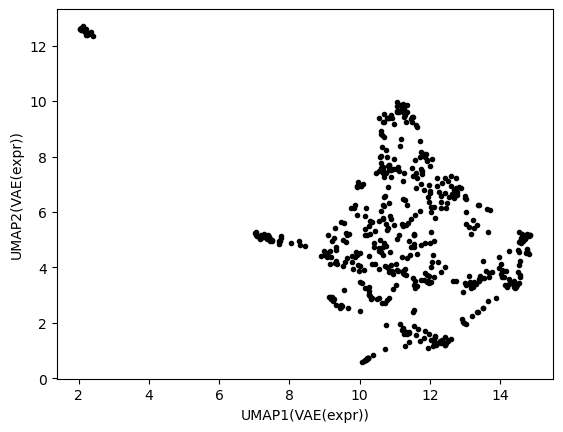

: 

: 

In [ ]:
plt.figure() 
plt.plot(u[:, 0], u[:, 1], 'k.')
plt.xlabel('UMAP1(VAE(expr))')
plt.ylabel('UMAP2(VAE(expr))') 
plt.show()

: 

In [ ]:
expr.shape

(511, 19938)

: 

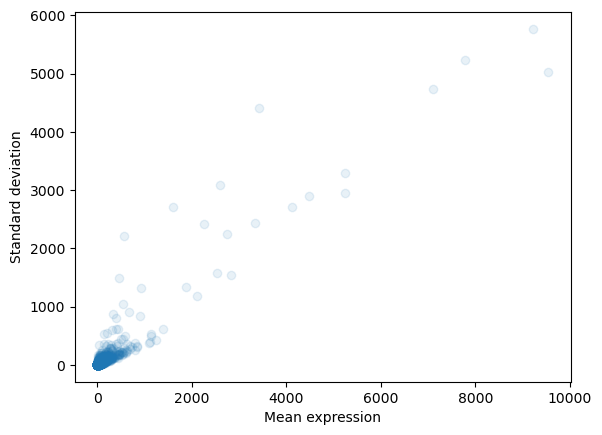

: 

In [ ]:
gene_stds = expr.std(axis=0)
gene_means = expr.mean(axis=0)
plt.figure() 
plt.scatter(gene_means, gene_stds, alpha=0.1)
plt.xlabel('Mean expression')
plt.ylabel('Standard deviation')
plt.show()


: 

In [ ]:
expr.gene_id.nunique()

60660

: 

In [ ]:
expr.gene_name.nunique()

59427

: 

In [ ]:
expr.id.nunique()

511

: 

In [ ]:
expr.groupby('gene_type').count()[['gene_id']]

gene_id
gene_type                                   
IG_C_gene                               7154
IG_C_pseudogene                         4599
IG_D_gene                              18907
IG_J_gene                               9198
IG_J_pseudogene                         1533
IG_V_gene                              74095
IG_V_pseudogene                        95557
IG_pseudogene                            511
Mt_rRNA                                 1022
Mt_tRNA                                11242
TEC                                   540127
TR_C_gene                               3066
TR_D_gene                               2044
TR_J_gene                              40369
TR_J_pseudogene                         2044
TR_V_gene                              54166
TR_V_pseudogene                        16863
lncRNA                               8636411
miRNA                                 961191
misc_RNA                             1130332
polymorphic_pseudogene                 24528
processed_pseudogene                 5195337
protein_coding                      10200582
pseudogene                              9198
rRNA                                   24017
rRNA_pseudogene                       253967
ribozyme                                4088
sRNA                                    2555
scRNA                                    511
scaRNA                                 25039
snRNA                                 971411
snoRNA                                481873
transcribed_processed_pseudogene      255500
transcribed_unitary_pseudogene         70518
transcribed_unprocessed_pseudogene    479829
translated_processed_pseudogene         1022
translated_unprocessed_pseudogene        511
unitary_pseudogene                     50078
unprocessed_pseudogene               1335754
vault_RNA                                511

: 

: 